# Binary-Class Tabular Model for Kaggle Playground Series Season 3 Episode 3 Using Python and XGBoost
### David Lowe
### February 1, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 3 dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the IBM HR Analytics Employee Attrition & Performance dataset. Feature distributions are close to but different from the original.

ANALYSIS: The performance of the preliminary XGBoost model achieved a ROC/AUC benchmark of 0.8485 after training. When we processed the test dataset with the final model, the model achieved a ROC/AUC score of 0.8969.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 3

Dataset ML Model: Binary-Class classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e3

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e3/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Jan 27 21:07:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'Attrition'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10

# Set default modeling scoring metric
SCORING_METRIC = 'roc_auc'

# Define the directory locations and file names
ORIGINAL_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e03/WA_Fn-UseC_-HR-Employee-Attrition.csv'
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e03/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e03/test.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e03/sample_submission.csv'
SUBMISSION_FILE = 'submission_xgboost_'

In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [9]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  Age     BusinessTravel  DailyRate              Department  \
0   0   36  Travel_Frequently        599  Research & Development   
1   1   35      Travel_Rarely        921                   Sales   
2   2   32      Travel_Rarely        718                   Sales   
3   3   38      Travel_Rarely       1488  Research & Development   
4   4   50      Travel_Rarely       1017  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  \
0                24          3        Medical              1   
1                 8          3          Other              1   
2                26          3      Marketing              1   
3                 2          3        Medical              1   
4                 5          4        Medical              1   

   EnvironmentSatisfaction  ... StandardHours  StockOptionLevel  \
0                        4  ...            80                 1   
1                        1  ...            80                 1   
2    

In [10]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [11]:
print(df_dataset_import.describe())

                id          Age    DailyRate  DistanceFromHome    Education  \
count  1677.000000  1677.000000  1677.000000       1677.000000  1677.000000   
mean    838.000000    36.036971   892.749553          8.683959     2.937984   
std     484.252517     8.507112   374.496259          7.826143     1.039078   
min       0.000000    18.000000   107.000000          1.000000     1.000000   
25%     419.000000    30.000000   589.000000          2.000000     2.000000   
50%     838.000000    35.000000   890.000000          7.000000     3.000000   
75%    1257.000000    41.000000  1223.000000         12.000000     4.000000   
max    1676.000000    60.000000  3921.000000         29.000000    15.000000   

       EmployeeCount  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count         1677.0              1677.000000  1677.000000     1677.000000   
mean             1.0                 2.757901    67.798450        2.782349   
std              0.0                 1.086835    19.43

In [12]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

In [13]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Attrition
0    1477
1     200
dtype: int64


### 1.d) Data Cleaning

In [14]:
def clean_Attrition(target_col):
    # print(target_col)
    if target_col == 'Yes':
        return 1
    else:
        return 0

In [15]:
# Fetch the original dataset and use it to supplement the training
df_dataset_original = pd.read_csv(ORIGINAL_DATASET)
df_dataset_original.pop('EmployeeNumber')
df_dataset_original.insert(len(df_dataset_original.columns)-1, 'Attrition', df_dataset_original.pop('Attrition'))
df_dataset_original['Attrition'] = df_dataset_original['Attrition'].apply(clean_Attrition)
# df_dataset_original['is_synthetic'] = 0

# Take a peek at the dataframe after import
print(df_dataset_original.head())

   Age     BusinessTravel  DailyRate              Department  \
0   41      Travel_Rarely       1102                   Sales   
1   49  Travel_Frequently        279  Research & Development   
2   37      Travel_Rarely       1373  Research & Development   
3   33  Travel_Frequently       1392  Research & Development   
4   27      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  \
0                 1          2  Life Sciences              1   
1                 8          1  Life Sciences              1   
2                 2          2          Other              1   
3                 3          4  Life Sciences              1   
4                 2          1        Medical              1   

   EnvironmentSatisfaction  Gender  ...  StandardHours  StockOptionLevel  \
0                        2  Female  ...             80                 0   
1                        3    Male  ...             80                 1   
2 

In [16]:
df_dataset_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   BusinessTravel            1470 non-null   object
 2   DailyRate                 1470 non-null   int64 
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EmployeeCount             1470 non-null   int64 
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [17]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import.pop('id')
# df_dataset_import['is_synthetic'] = 1

df_dataset_import = pd.concat([df_dataset_import, df_dataset_original],
                              ignore_index=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       3147 non-null   int64 
 1   BusinessTravel            3147 non-null   object
 2   DailyRate                 3147 non-null   int64 
 3   Department                3147 non-null   object
 4   DistanceFromHome          3147 non-null   int64 
 5   Education                 3147 non-null   int64 
 6   EducationField            3147 non-null   object
 7   EmployeeCount             3147 non-null   int64 
 8   EnvironmentSatisfaction   3147 non-null   int64 
 9   Gender                    3147 non-null   object
 10  HourlyRate                3147 non-null   int64 
 11  JobInvolvement            3147 non-null   int64 
 12  JobLevel                  3147 non-null   int64 
 13  JobRole                   3147 non-null   object
 14  JobSatisfaction         

In [18]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Drop the columns that has no predictive value
df_dataset_import.drop(columns=['EmployeeCount','StandardHours'], inplace=True)

# Apply additional feature engineering tasks suggested by the top competitor
df_dataset_import['MonthlyIncome/Age'] = df_dataset_import['MonthlyIncome'] / df_dataset_import['Age']
df_dataset_import["Age_risk"] = (df_dataset_import["Age"] < 34).astype(int)
df_dataset_import["HourlyRate_risk"] = (df_dataset_import["HourlyRate"] < 60).astype(int)
df_dataset_import["Distance_risk"] = (df_dataset_import["DistanceFromHome"] >= 20).astype(int)
df_dataset_import["YearsAtCo_risk"] = (df_dataset_import["YearsAtCompany"] < 4).astype(int)
df_dataset_import['NumCompaniesWorked'] = df_dataset_import['NumCompaniesWorked'].replace(0, 1)
df_dataset_import['AverageTenure'] = df_dataset_import["TotalWorkingYears"] / df_dataset_import["NumCompaniesWorked"]
df_dataset_import['JobHopper'] = ((df_dataset_import["NumCompaniesWorked"] > 2) & (df_dataset_import["AverageTenure"] < 2.0)).astype(int)
df_dataset_import["AttritionRisk"] = df_dataset_import["Age_risk"] + df_dataset_import["HourlyRate_risk"] + df_dataset_import["Distance_risk"] + df_dataset_import["YearsAtCo_risk"] + df_dataset_import['JobHopper']

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

   Age     BusinessTravel  DailyRate              Department  \
0   36  Travel_Frequently        599  Research & Development   
1   35      Travel_Rarely        921                   Sales   
2   32      Travel_Rarely        718                   Sales   
3   38      Travel_Rarely       1488  Research & Development   
4   50      Travel_Rarely       1017  Research & Development   

   DistanceFromHome  Education EducationField  EnvironmentSatisfaction  \
0                24          3        Medical                        4   
1                 8          3          Other                        1   
2                26          3      Marketing                        3   
3                 2          3        Medical                        3   
4                 5          4        Medical                        2   

   Gender  HourlyRate  ...  YearsWithCurrManager  target MonthlyIncome/Age  \
0    Male          42  ...                     8       0         72.111111   
1    Male     

In [19]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       3147 non-null   int64  
 1   BusinessTravel            3147 non-null   object 
 2   DailyRate                 3147 non-null   int64  
 3   Department                3147 non-null   object 
 4   DistanceFromHome          3147 non-null   int64  
 5   Education                 3147 non-null   int64  
 6   EducationField            3147 non-null   object 
 7   EnvironmentSatisfaction   3147 non-null   int64  
 8   Gender                    3147 non-null   object 
 9   HourlyRate                3147 non-null   int64  
 10  JobInvolvement            3147 non-null   int64  
 11  JobLevel                  3147 non-null   int64  
 12  JobRole                   3147 non-null   object 
 13  JobSatisfaction           3147 non-null   int64  
 14  MaritalS

In [20]:
print(df_dataset_import.describe())

               Age    DailyRate  DistanceFromHome    Education  \
count  3147.000000  3147.000000       3147.000000  3147.000000   
mean     36.451223   850.586273          8.921513     2.926279   
std       8.815861   390.859919          7.961278     1.032051   
min      18.000000   102.000000          1.000000     1.000000   
25%      30.000000   543.000000          2.000000     2.000000   
50%      35.000000   852.000000          7.000000     3.000000   
75%      42.000000  1198.500000         13.000000     4.000000   
max      60.000000  3921.000000         29.000000    15.000000   

       EnvironmentSatisfaction   HourlyRate  JobInvolvement     JobLevel  \
count              3147.000000  3147.000000     3147.000000  3147.000000   
mean                  2.741023    66.907531        2.757865     2.029234   
std                   1.089733    19.877918        0.680183     1.094590   
min                   1.000000    30.000000        1.000000     1.000000   
25%                   2.0

In [21]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
target                      0
MonthlyIncome/Age           0
Age_risk  

In [22]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
0    2710
1     437
dtype: int64


### 1.e) Splitting Data into Sets

In [23]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (3147, 40) df_features_train.shape: (3147, 39) df_target_train.shape: (3147,)


### 1.f) Set up the parameters for data visualization

In [24]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [25]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

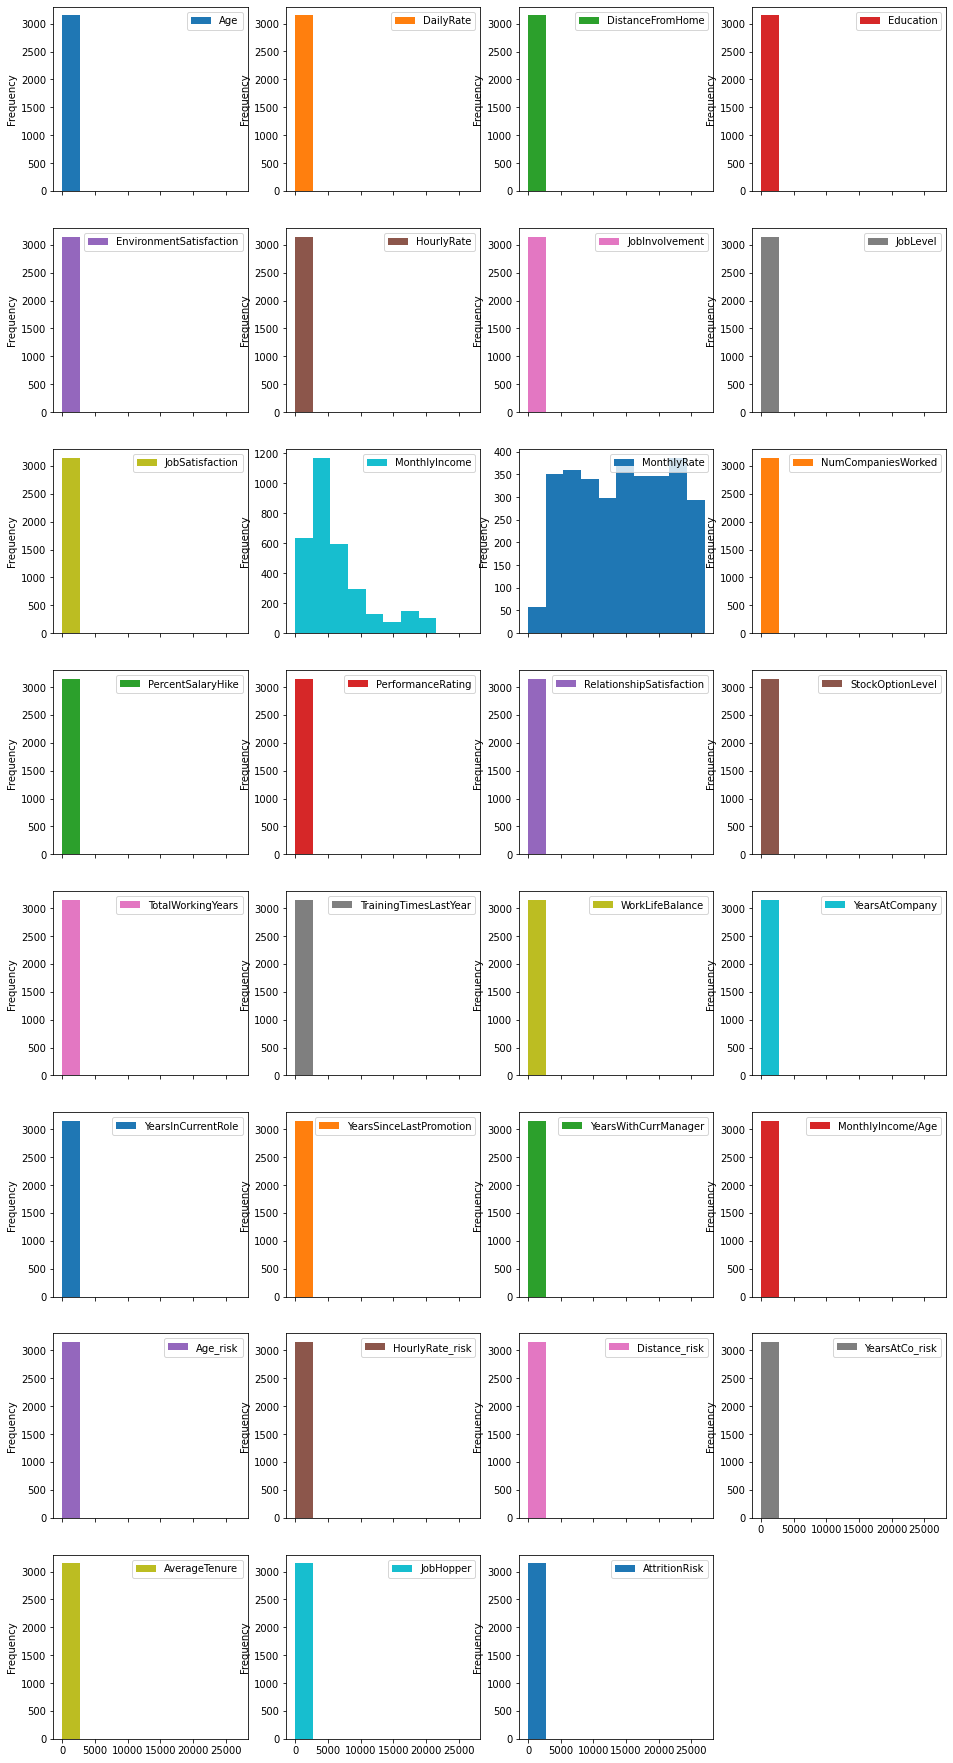

In [27]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

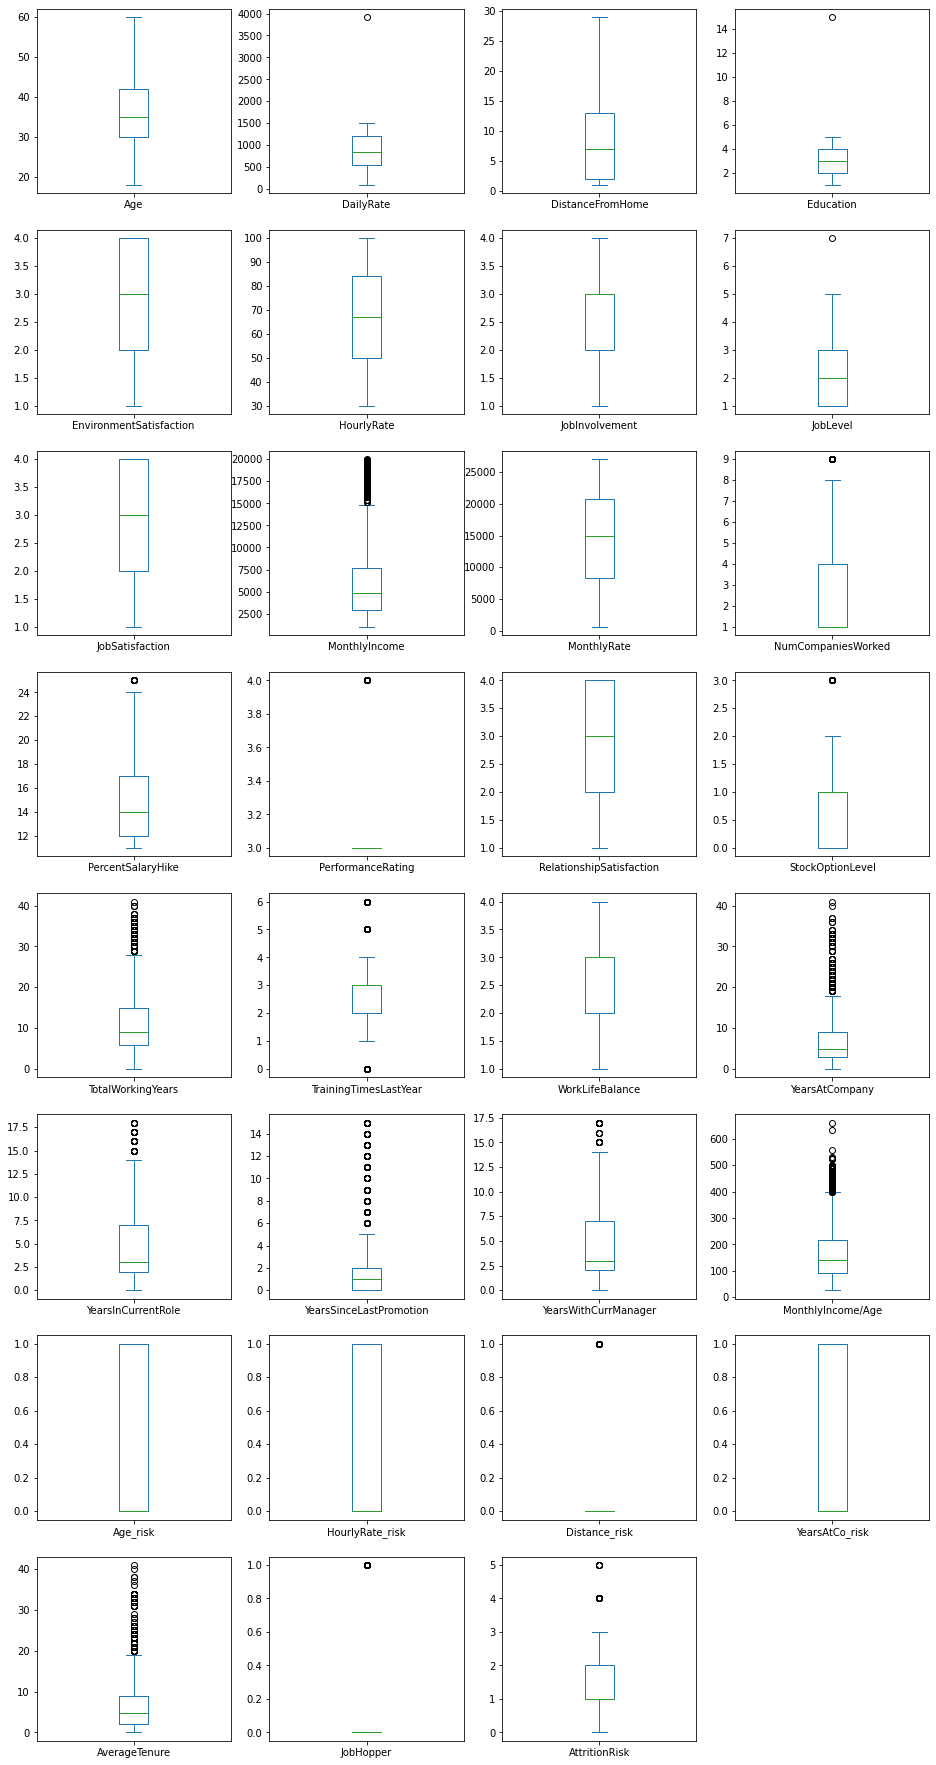

In [28]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

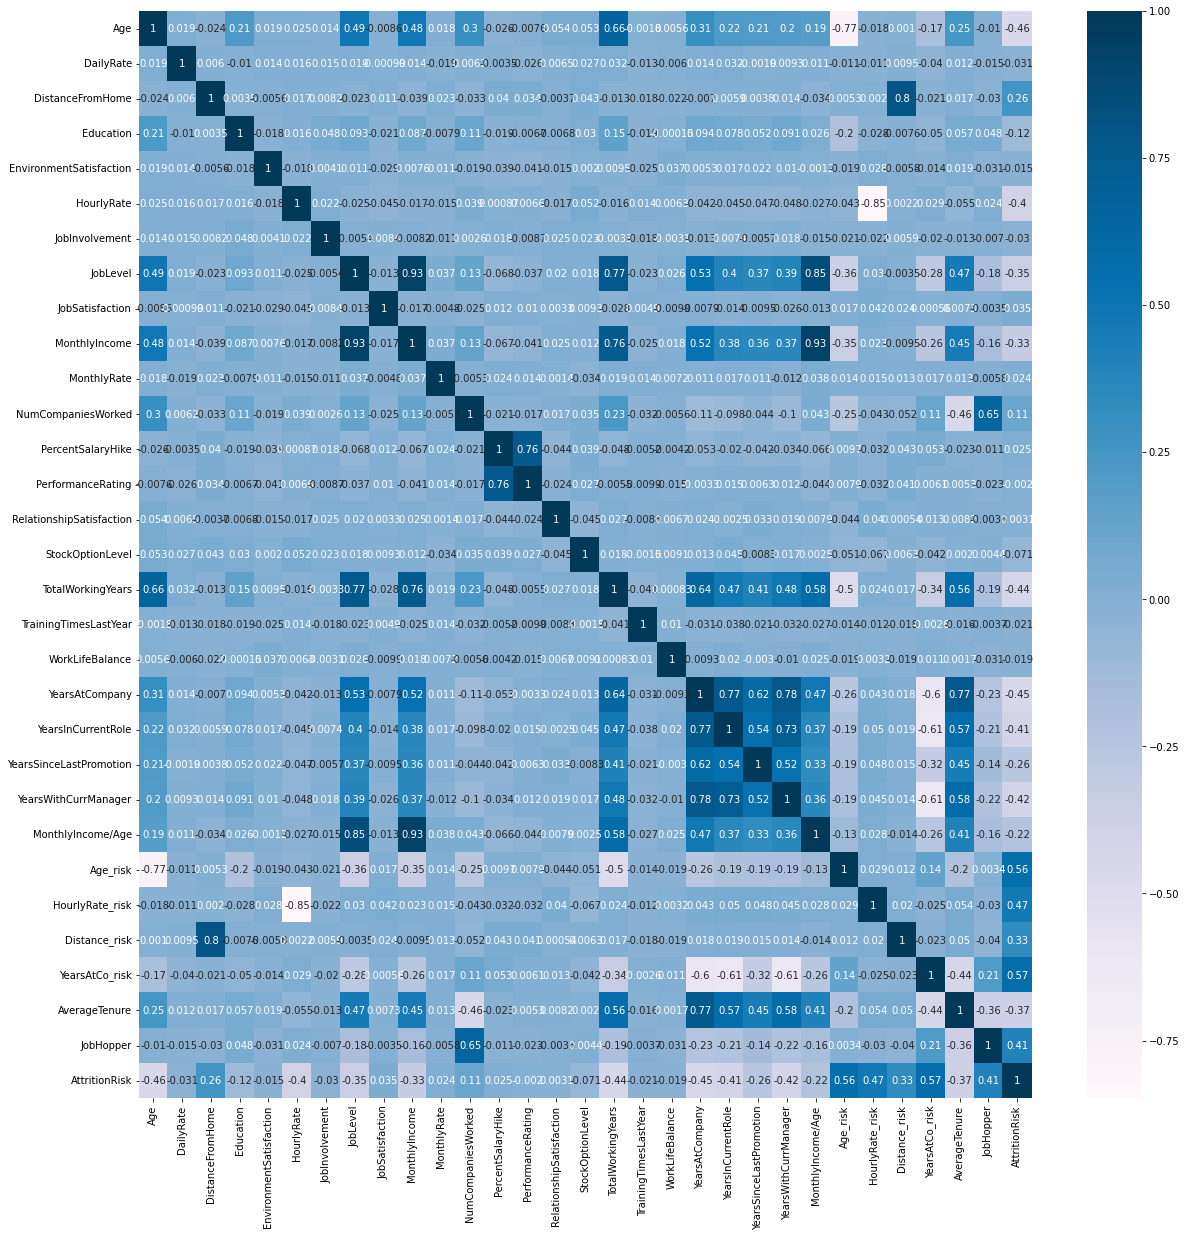

In [29]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [30]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [31]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [32]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['float','int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 31
Number of categorical columns: 8
Total number of columns in the feature dataframe: 39


In [33]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
    ], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (3147, 39) to array_features_train.shape: (3147, 60)


In [34]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
# array_features_train = df_features_train.to_numpy()
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)

### 3.b) Training Data Balancing

In [35]:
# Perform SMOTE transformation on the training data (Block #1 of 2)
X_train_imbal = array_features_train
y_train_imbal = array_target_train
print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

X_train_imbal.shape: (3147, 60) y_train_imbal.shape: (3147,)


In [36]:
# Perform SMOTE transformation on the training data (Block #2 of 2)
print ('Original class distribution - 1: {} | 0: {}'.format((array_target_train==1).sum(), (array_target_train==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.5, random_state=RNG_SEED)
under_sample = RandomUnderSampler(sampling_strategy=0.30, random_state=RNG_SEED)
# steps = [('o', over_sample), ('u', under_sample)]
steps = [('u', under_sample)]
sample_pipeline = Pipeline(steps=steps)
array_features_train, array_target_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
print ('Resampled class distribution - 1: {} | 0: {}'.format((array_target_train==1).sum(), (array_target_train==0).sum()))

Original class distribution - 1: 437 | 0: 2710
Resampled class distribution - 1: 437 | 0: 1456


### 3.c) Feature Selection

In [37]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [38]:
# Finalize the training dataset for the modeling activities
# array_features_train = preprocessor.fit_transform(df_features_train)
# array_features_train = df_features_train.to_numpy()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (1893, 60) array_target_train.shape: (1893,)


In [39]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [40]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [41]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [42]:
train_models.append(('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')))

In [43]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.838952 (0.026160)
XGBClassifier(eval_metric='logloss', random_state=888, tree_method='gpu_hist',
              use_label_encoder=False)
Model training time: 0:00:55.672968 

Average metrics (roc_auc) from all models: 0.8389522700059221
Total training time for all models: 0:00:55.688512


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   55.7s finished


### 4.b) Algorithm Tuning

In [44]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [45]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 45 candidates, totalling 450 fits
Best: 0.839704 using {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
0.838952 (0.026160) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.839477 (0.027393) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.835924 (0.027670) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.832463 (0.027647) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.831917 (0.026772) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.838214 (0.023657) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.836381 (0.026443) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.832479 (0.024294) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.829558 (0.023290) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.827067 (0.022834) with: {'max_depth': 3, 'min_child_weight': 2, 'n_est

In [46]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 3
Best min_child_weight parameter: 3
Best n_estimators parameter: 100


In [47]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best: 0.848530 using {'colsample_bytree': 0.7, 'subsample': 0.7}
0.848530 (0.023784) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.845957 (0.019501) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.844910 (0.024202) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.843014 (0.022410) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.846894 (0.022182) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.847858 (0.021018) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.842730 (0.025139) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.841177 (0.025250) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.848148 (0.024853) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.847819 (0.020792) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.845531 (0.025989) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.840179 (0.027814) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.846795 (0.023811) with: {'cols

In [48]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 0.7
Best subsample parameter: 0.7


### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


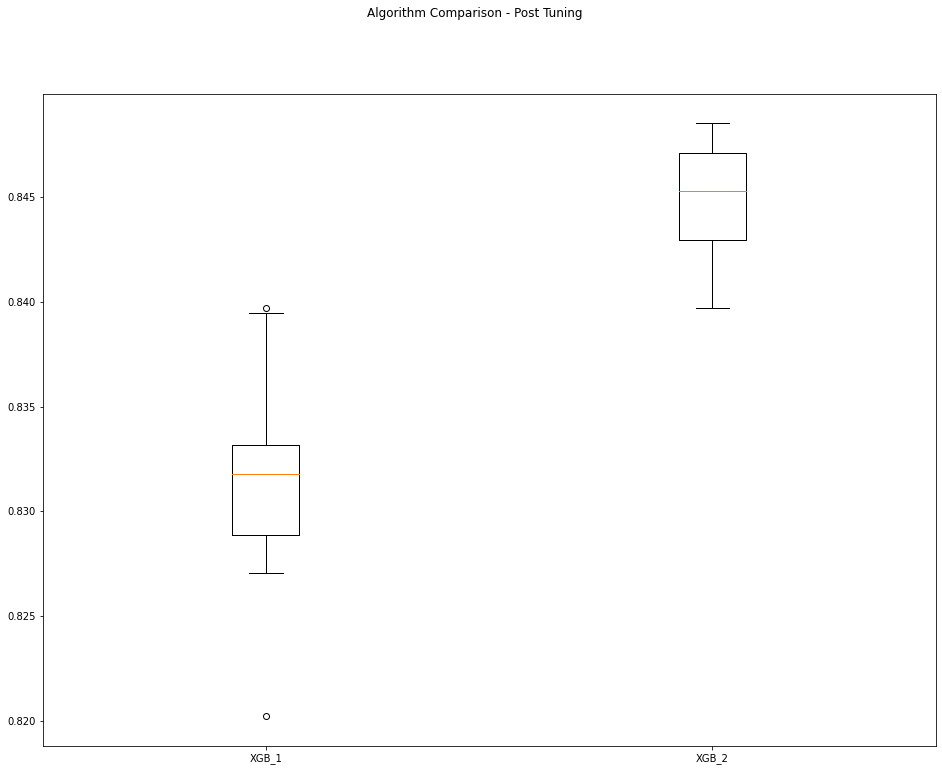

In [49]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [50]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [51]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [52]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE, random_state=RNG_SEED,
                            n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(colsample_bytree=0.7, eval_metric='logloss', min_child_weight=3,
              random_state=888, subsample=0.7, tree_method='gpu_hist',
              use_label_encoder=False)


### 5.b) Load Test Dataset and Make Predictions

In [53]:
df_features_test = pd.read_csv(TEST_DATASET)
# df_features_test['is_synthetic'] = 1

# Drop the columns that has no predictive value
df_features_test.drop(columns=['EmployeeCount','StandardHours'], inplace=True)

# Take a peek at the dataframe after import
print(df_features_test.head())

     id  Age     BusinessTravel  DailyRate              Department  \
0  1677   19         Non-Travel        992  Research & Development   
1  1678   45      Travel_Rarely       1136                   Sales   
2  1679   37      Travel_Rarely        155  Research & Development   
3  1680   32      Travel_Rarely        688  Research & Development   
4  1681   29  Travel_Frequently        464  Research & Development   

   DistanceFromHome  Education EducationField  EnvironmentSatisfaction Gender  \
0                 1          1        Medical                        4   Male   
1                 4          4      Marketing                        3   Male   
2                13          3  Life Sciences                        4   Male   
3                 1          4  Life Sciences                        3   Male   
4                 9          1  Life Sciences                        3   Male   

   ...  PerformanceRating  RelationshipSatisfaction  StockOptionLevel  \
0  ...             

In [54]:
df_features_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1119 non-null   int64 
 1   Age                       1119 non-null   int64 
 2   BusinessTravel            1119 non-null   object
 3   DailyRate                 1119 non-null   int64 
 4   Department                1119 non-null   object
 5   DistanceFromHome          1119 non-null   int64 
 6   Education                 1119 non-null   int64 
 7   EducationField            1119 non-null   object
 8   EnvironmentSatisfaction   1119 non-null   int64 
 9   Gender                    1119 non-null   object
 10  HourlyRate                1119 non-null   int64 
 11  JobInvolvement            1119 non-null   int64 
 12  JobLevel                  1119 non-null   int64 
 13  JobRole                   1119 non-null   object
 14  JobSatisfaction         

In [55]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

     id
0  1677
1  1678
2  1679
3  1680
4  1681


In [56]:
# Dropping unique identifier and unnecessary features
df_features_test.drop(columns=[id_column_name,], inplace=True)

# Apply additional feature engineering tasks suggested by the top competitor
df_features_test['MonthlyIncome/Age'] = df_features_test['MonthlyIncome'] / df_features_test['Age']
df_features_test["Age_risk"] = (df_features_test["Age"] < 34).astype(int)
df_features_test["HourlyRate_risk"] = (df_features_test["HourlyRate"] < 60).astype(int)
df_features_test["Distance_risk"] = (df_features_test["DistanceFromHome"] >= 20).astype(int)
df_features_test["YearsAtCo_risk"] = (df_features_test["YearsAtCompany"] < 4).astype(int)
df_features_test['NumCompaniesWorked'] = df_features_test['NumCompaniesWorked'].replace(0, 1)
df_features_test['AverageTenure'] = df_features_test["TotalWorkingYears"] / df_features_test["NumCompaniesWorked"]
df_features_test['JobHopper'] = ((df_features_test["NumCompaniesWorked"] > 2) & (df_features_test["AverageTenure"] < 2.0)).astype(int)
df_features_test["AttritionRisk"] = df_features_test["Age_risk"] + df_features_test["HourlyRate_risk"] + df_features_test["Distance_risk"] + df_features_test["YearsAtCo_risk"] + df_features_test['JobHopper']

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   Age     BusinessTravel  DailyRate              Department  \
0   19         Non-Travel        992  Research & Development   
1   45      Travel_Rarely       1136                   Sales   
2   37      Travel_Rarely        155  Research & Development   
3   32      Travel_Rarely        688  Research & Development   
4   29  Travel_Frequently        464  Research & Development   

   DistanceFromHome  Education EducationField  EnvironmentSatisfaction Gender  \
0                 1          1        Medical                        4   Male   
1                 4          4      Marketing                        3   Male   
2                13          3  Life Sciences                        4   Male   
3                 1          4  Life Sciences                        3   Male   
4                 9          1  Life Sciences                        3   Male   

   HourlyRate  ...  YearsSinceLastPromotion  YearsWithCurrManager  \
0          43  ...                        0                

In [57]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (1119, 39) to array_features_test.shape: (1119, 60)


In [58]:
# Make batched predictions
test_predictions =  final_model.predict_proba(array_features_test)
print(test_predictions)

[[0.59357584 0.40642413]
 [0.8668494  0.1331506 ]
 [0.924507   0.075493  ]
 ...
 [0.912605   0.08739499]
 [0.9461649  0.05383508]
 [0.95808244 0.04191756]]


In [59]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

Attrition


In [60]:
df_kaggle_submission[submission_header] = test_predictions[:,1]
print(df_kaggle_submission.head())

     id  Attrition
0  1677   0.406424
1  1678   0.133151
2  1679   0.075493
3  1680   0.103231
4  1681   0.890283


In [61]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_xgboost_20230127-2113.csv


In [62]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [63]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:06:05.713951
